In [ ]:
import os
import tensorflow as tf

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [ ]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import wandb
# from wandb.keras import WandbCallback
import os
import random
from google.colab.patches import cv2_imshow
import cv2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('cnontent/')

Mounted at cnontent/


In [ ]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [ ]:
ls

emnist-byclass-test.csv   images/  my_lenet5_emnist_model_20220515.h5  wandb/
emnist-byclass-train.csv  mobile2  our_handmade_dataset.csv


In [ ]:
model = tf.keras.models.load_model('my_lenet5_emnist_model_20220515.h5')

In [ ]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [ ]:
train_csv, test_csv = [], []
train_csv = pd.read_csv("./emnist-byclass-train.csv", header=None)

In [ ]:
train_data, train_label = convert_data_csv_to_numpy(train_csv, sorting = False)
train_csv = []

In [ ]:
boundary = int((train_data.shape[0])*0.8)
print(boundary)

558345


In [ ]:
def data_crop(data, mean):
  # images = np.zeros((data.shape[0], 20, 20))
  for i in range(data.shape[0]):
    image = data[i]
    first_norm = 255/np.max(image)
    image = (image*first_norm).astype(np.uint8)

    _, binary_image = cv2.threshold(image.astype(np.uint8), 20, 255, cv2.THRESH_BINARY)
    min_max_list = np.where(binary_image==255)
    x_min, x_max = np.min(min_max_list[1]), np.max(min_max_list[1])
    y_min, y_max = np.min(min_max_list[0]), np.max(min_max_list[0])

    if abs(x_max - x_min) >abs(y_max - y_min):
      add_sub_factor = (abs(x_max - x_min) - abs(y_max - y_min))//2
      y_min = max(0, y_min-add_sub_factor-1)
      y_max = min(27, y_max+add_sub_factor+1)

    if abs(y_max - y_min) > abs(x_max - x_min):
      add_sub_factor = (abs(y_max - y_min)-abs(x_max - x_min))//2
      x_min = max(0, x_min-add_sub_factor-1)
      x_max = min(27, x_max+add_sub_factor+1)
    # print(x_min, x_max)
    # print(y_min, y_max)
    data[i] = np.pad(cv2.resize(image.astype(np.uint8)[y_min:y_max, x_min:x_max], (20, 20)), ((4, 4), (4, 4)), 'constant', constant_values = 0)
    second_norm = 255/np.max(data[i])
    data[i] = (data[i]*second_norm).astype(np.uint8)

In [ ]:
test_csv = pd.read_csv("./emnist-byclass-test.csv", header=None)
hand_made_csv = pd.read_csv("./our_handmade_dataset.csv", header=None)

In [ ]:
test_data, test_label = convert_data_csv_to_numpy(test_csv, sorting = False)
hand_data, hand_label = convert_data_csv_to_numpy(hand_made_csv, sorting = False)
# test_csv, hand_made_csv = [], []

In [ ]:
test_data = test_data.reshape(-1, 28, 28)
hand_data = hand_data.reshape(-1, 28, 28)

In [ ]:
mean = np.mean(train_data[:boundary])
print(mean)
print(np.mean(hand_data))

44.27018272706821
8.979617038347596


In [ ]:
data_crop(hand_data, np.mean(hand_data))

In [ ]:
hand_data.shape

(2480, 28, 28)

In [ ]:
mean = np.mean(train_data[:boundary])
print(mean)
print(np.mean(hand_data))

44.27018272706821
10.98448043531929


255
0


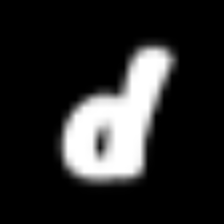

In [ ]:
a = cv2.resize(hand_data[1707].astype(np.uint8).T, (224, 224))
# norm = 255/np.max(a)
# a = (a*norm).astype(np.uint8)
print(np.max(a))
print(np.min(a))
# a[a>np.mean(hand_data)*2] +=diff
cv2_imshow(a)

In [ ]:
# 기존 model weight + pixel_min_max_crop

In [ ]:
model.evaluate(test_data/255., test_label)

3636/3636 [==============================] - 11s 3ms/step - loss: 0.3802 - accuracy: 0.8619


[0.38020074367523193, 0.8619275689125061]

In [ ]:
model.evaluate(hand_data/255., hand_label)

78/78 [==============================] - 0s 4ms/step - loss: 2.5577 - accuracy: 0.3883


[2.557722568511963, 0.3883064389228821]

In [ ]:
# 기존 model weight + pixel_min_max_weighted_crop -> (max-min)//2

In [ ]:
model.evaluate(test_data/255., test_label)

3636/3636 [==============================] - 9s 2ms/step - loss: 0.3665 - accuracy: 0.8658


[0.3664874732494354, 0.8657703399658203]

In [ ]:
model.evaluate(hand_data/255., hand_label)

78/78 [==============================] - 0s 3ms/step - loss: 2.3886 - accuracy: 0.4448


[2.388550281524658, 0.4447580575942993]

In [ ]:
# train x -> 현재 모델 weight에서 handmade 데이터 set만 변경

In [ ]:
model.evaluate(test_data/255., test_label)

3636/3636 [==============================] - 12s 3ms/step - loss: 0.3567 - accuracy: 0.8709


[0.35673031210899353, 0.8708939552307129]

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 32)       1

In [ ]:
model.evaluate(hand_data/255., hand_label)

78/78 [==============================] - 9s 3ms/step - loss: 1.1534 - accuracy: 0.6335


[1.153355598449707, 0.6334677338600159]

In [ ]:
model.evaluate(hand_data/255., hand_label)

78/78 [==============================] - 0s 3ms/step - loss: 1.3894 - accuracy: 0.5585


[1.3894001245498657, 0.5584677457809448]